In [1]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution


%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

In [2]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack', process_cohorts=False):
    # method: PCA
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    cohorts = df.batch_number.unique().tolist()
    ind = df.index
    non_gene_columns = [_col for _col in df.columns if 'GenX' not in _col]
    red_data_dict = {}
    if process_cohorts:
        for _cohort in cohorts:
            ch = df['batch_number']==_cohort
            X = df.loc[ch, gene_columns]
            if X.shape[0]>min_samples:
                # PCA 3
                reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
                # put components in a dictionary with cohort as key
                X_red = reducer.fit_transform(X)
                #
                red_data_dict[_cohort] = {}
                red_data_dict[_cohort]['data'] = X_red
                red_data_dict[_cohort]['reducer'] = reducer
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    
    red_cols = ['red_'+str(i) for i in range(0,n_comp)]
    df_red = pd.DataFrame(data=X_red, index=ind, columns=red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df[non_gene_columns].merge(df_red, how='inner', left_index=True, right_index=True)
    red_data_dict['ALL']['reducer'] = reducer
    
    
    return red_data_dict

In [3]:
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

# significances of differences between pheno's.
def distribution_difference_phenotypes(df, batches=[], phenotypes=[]):
    tot_res = []
    for _phenotype in phenotypes:    
        res = []
        for _batch_nr in batches:
            _all = df.loc[df.batch_number!=_batch_nr][_phenotype]
            _batch = df.loc[df.batch_number==_batch_nr][_phenotype]
            _ks = ks2(_all.values, _batch.values)
            _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
            try:
                _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
                _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            except ValueError as e:
                print('ValError, defaulting to NaN')
                _w1 = _w2 = np.nan

            res.append({'batch_number': _batch_nr,
                        'ks_stat': _ks[0], 'ks_p': _ks[1],
                        'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                        'w1_dist': _w1, 'w2_dist': _w2})
        res_df = pd.DataFrame(res)
        tot_res.append({_phenotype: res_df})
    return tot_res

def _cohort_bias_metrics_colwise_reduced(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


In [4]:
#@jit
def median_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        median_batch = np.median(x[:, batch_ids[_batch]], axis=1)
        #median_all = np.median(x, axis=1)
        median_all = np.median(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = median_batch - median_all
        
    return delta 

@jit
def mean_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        mean_batch = np.mean(x[:, batch_ids[_batch]], axis=1)
        #mean_all = np.mean(x, axis=1)
        mean_all = np.mean(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = mean_batch - mean_all
        
    return delta 

# Load in data

In [6]:
# "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung"
# "/home/bramiozo/DATA/LungCancerResearch/" 
source_dir = "/media/bramiozo/DATA-FAST/genetic_expression/hackathon_2/Lung/"
RNA_ComBat_param = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_param.csv",
                               sep="\t", engine="python")
#RNA_ComBat_param.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_param.columns.tolist()]
#RNA_ComBat_param.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_param.index.tolist()]
###
RNA_ComBat_nonparam = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                               sep="\t", engine="python")
#RNA_ComBat_nonparam.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_nonparam.columns.tolist()]
#RNA_ComBat_nonparam.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_nonparam.index.tolist()]
###
#RNA_LSquantile = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_quantile_LS_.csv"
#                                    , sep=",", engine="python")
###
RNA_Raw = pd.read_csv(source_dir+"_prepped/gene_raw.csv", 
                      sep="\t", 
                      engine="python")
# RNAexpression_LSstandard_shifted
RNA_LSstandard = pd.read_csv(source_dir+"_prepped/RNAexpression_LSstandard_shifted.csv"
                                    , sep=",", engine="python")

In [7]:
#RNA_ComBat_param.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)
#RNA_ComBat_nonparam.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)

RNA_LSstandard.set_index('patient_nr', inplace=True)
#RNA_LSquantile.set_index('patient_nr', inplace=True)
RNA_Raw.set_index('GenX', inplace=True)
RNA_ComBat_nonparam.set_index('GenX', inplace=True)
RNA_ComBat_param.set_index('GenX', inplace=True)

TCGA_COLS = [_col for _col in RNA_ComBat_param.columns.tolist() if 'TCGA-' in _col]
RNA_ComBat_param = RNA_ComBat_param.copy().loc[:, TCGA_COLS]

TCGA_COLS = [_col for _col in RNA_ComBat_nonparam.columns.tolist() if 'TCGA-' in _col]
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().loc[:, TCGA_COLS]

# Add phenotypical data and transpose if necessary

In [8]:
RNA_Raw = RNA_Raw.copy().T
gc.collect()
RNA_ComBat_param = RNA_ComBat_param.copy().T
gc.collect()
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().T
gc.collect()

0

In [9]:
RNA_Raw.columns = ['GenX_'+_col for _col in RNA_Raw.columns.tolist()]
RNA_ComBat_param.columns = ['GenX_'+_col for _col in RNA_ComBat_param.columns.tolist()]
RNA_ComBat_nonparam.columns = ['GenX_'+_col for _col in RNA_ComBat_nonparam.columns.tolist()]

# load phenotypical data 

In [10]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']


In [11]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic
pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [12]:
#GenX_columns = [_col for _col in RNA_LSquantile.columns if 'GenX_' in _col]
#RNA_LSquantile = RNA_LSquantile.copy().loc[:, GenX_columns]
GenX_columns = [_col for _col in RNA_LSstandard.columns if 'GenX_' in _col]
RNA_LSstandard = RNA_LSstandard.copy().loc[:, GenX_columns]

In [13]:
data_dict = {'ComBat_param': RNA_ComBat_param, 
             'ComBat_nonparam': RNA_ComBat_nonparam,
             'LS_standard': RNA_LSstandard,
             #'LS_quantile': RNA_LSquantile,
             'raw': RNA_Raw}

In [14]:
for _key in data_dict.keys():
    data_dict[_key] = data_dict[_key].merge(pheno, how='left', left_index=True, right_index=True)

# Get principal components

In [15]:
data_reduced = {}
n_components = 50

for _key in data_dict.keys():
    print("Processing {} data: ".format(_key))
    data_reduced[_key] = _dim_reduction(data_dict[_key], min_samples=10, n_comp=n_components, method='PCA', pc_solver='arpack')

Processing ComBat_param data: 
Running reducer on all samples..
Processing ComBat_nonparam data: 
Running reducer on all samples..
Processing LS_standard data: 
Running reducer on all samples..
Processing raw data: 
Running reducer on all samples..


# Statistical analysis

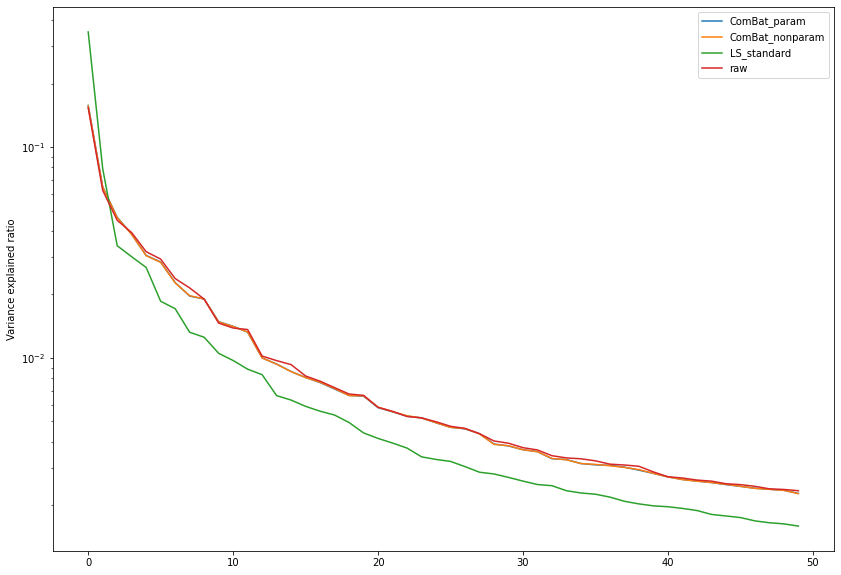

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

PC's for methylation data:ComBat_nonparam


Text(0.5, 0.98, 'ComBat_nonparam')

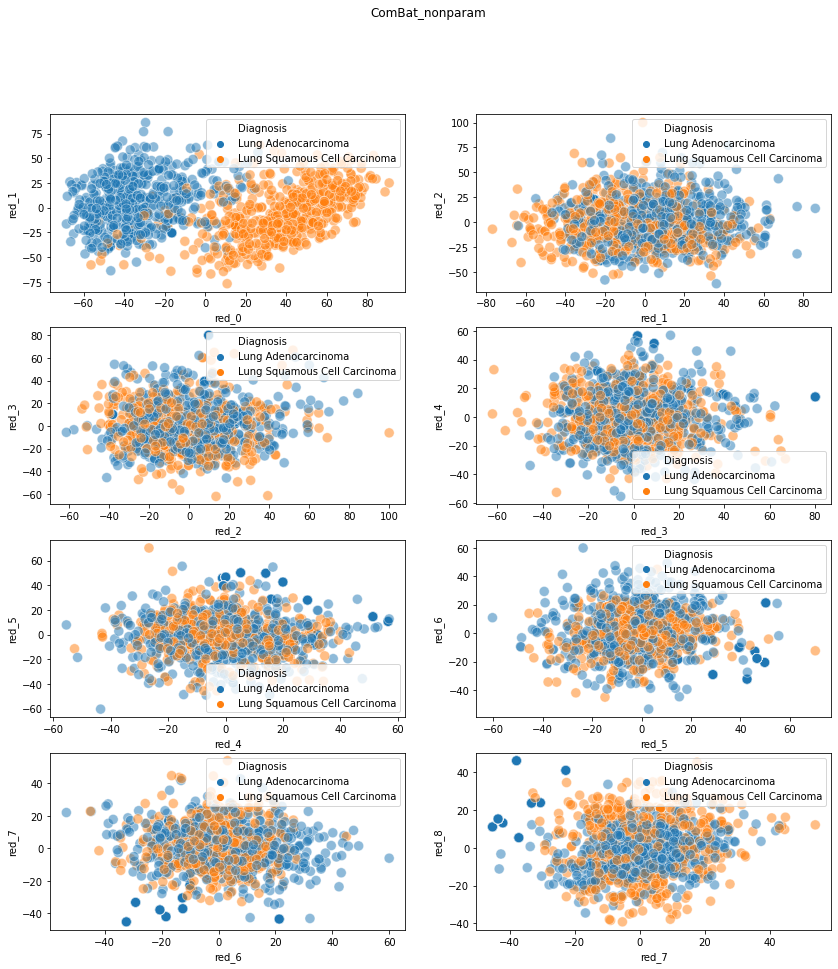

In [17]:
# check PCA, for first components, color by cancer diagnosis.
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(14,15))
key = 'ComBat_nonparam' # ComBat_param,ComBat_nonparam, LS_standard,raw
color_by = 'Diagnosis' # batch_number, Gender, Diagnosis
size_by = None
def_size = 100
style_by = None
print('PC\'s for methylation data:{}'.format(key))
sns.scatterplot(x='red_0', y='red_1', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_2', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_2', y='red_3', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_3', y='red_4', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_4', y='red_5', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_5', y='red_6', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_6', y='red_7', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_7', y='red_8', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
fig.suptitle(key)

In [18]:
_filter= (data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0]>0.015) | \
         (data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0]<-0.015)
pca_0_idx = np.argwhere(_filter)
Genes = data_dict['ComBat_nonparam'].columns[pca_0_idx]

<ipython-input-18-4fd53b9520b3>:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Genes = data_dict['ComBat_nonparam'].columns[pca_0_idx]


In [19]:
print("Important genes are for the first principal component: \n {}".format(Genes))

Important genes are for the first principal component: 
 [['GenX_GCLC.chr6.53497341.53616970.-']
 ['GenX_ENPP4.chr6.46129993.46146699.+']
 ['GenX_SEMA3F.chr3.50155045.50189075.+']
 ['GenX_AOC1.chr7.150824627.150861504.+']
 ['GenX_KLHL13.chrX.117897813.118117340.-']
 ['GenX_ICA1.chr7.8113184.8262687.-']
 ['GenX_TFPI.chr2.187464230.187565760.-']
 ['GenX_SLC7A2.chr8.17497088.17570573.+']
 ['GenX_PDK4.chr7.95583499.95596491.-']
 ['GenX_CRLF1.chr19.18572220.18607741.-']
 ['GenX_TMEM132A.chr11.60924463.60937159.+']
 ['GenX_DLX6.chr7.97005548.97011039.+']
 ['GenX_ALDH3B1.chr11.68008578.68029282.+']
 ['GenX_PRSS21.chr16.2817180.2826304.+']
 ['GenX_CACNA2D2.chr3.50362799.50504244.-']
 ['GenX_RHOBTB2.chr8.22987417.23020199.+']
 ['GenX_CD9.chr12.6199715.6238271.+']
 ['GenX_NCAPD2.chr12.6493356.6531955.+']
 ['GenX_ALOX5.chr10.45374176.45446119.+']
 ['GenX_MVP.chr16.29820394.29848039.+']
 ['GenX_GPRC5A.chr12.12890782.12917937.+']
 ['GenX_VSIG2.chr11.124747472.124752238.-']
 ['GenX_MARCO.chr2.118942

In [20]:
np.quantile(data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0], 0.005)

-0.01696145185762105

We still see a very strong separation between the two diagnoses after the CBC-correction using ComBat.

What is the seperability of the two classes in the first principal components?

In [21]:
key = 'raw'  # 'ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'
red_cols = ['red_'+str(i) for i in range(0, n_components)]
score_list = []
for _key in data_reduced.keys():
    for idx, _red in enumerate(red_cols):
        scores = ks2(data1=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Adenocarcinoma'").loc[:,_red], 
           data2=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Squamous Cell Carcinoma'").loc[:,_red])
        
        score_list.append({'dim': _red, 
                           'dim_num': idx,
                           'score': scores[0],
                           'pval': scores[1], 
                           'set': _key})
score_df = pd.DataFrame(score_list)

Text(0.5, 0.98, 'Separability of cancer diagnoses')

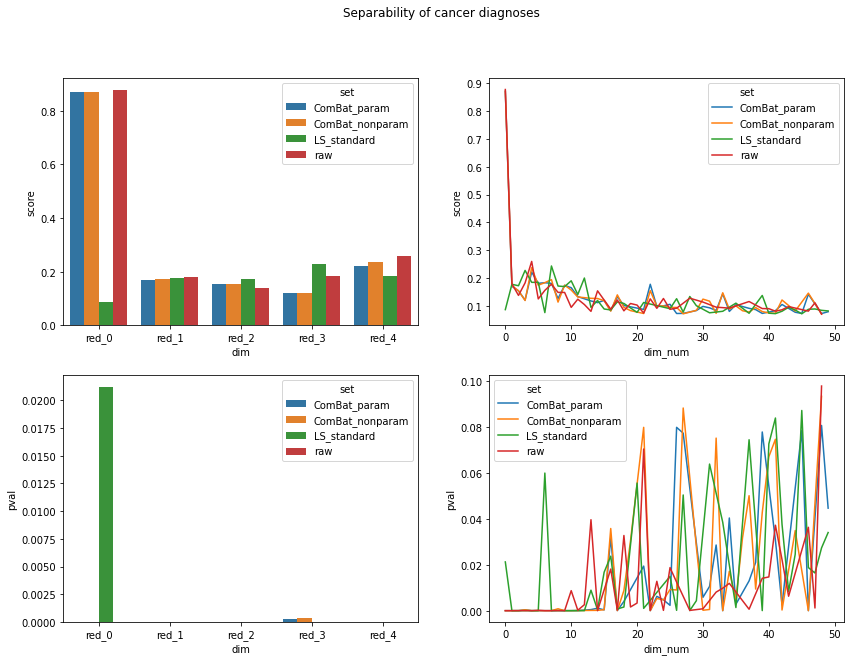

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

pval_min = 0.1

sns.barplot(x='dim', y='score', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4'])) &
                              (score_df.pval<pval_min)], ax=ax[0,0])
sns.lineplot(x='dim_num', y='score', hue='set', 
             data=score_df.loc[score_df.pval<pval_min], ax=ax[0,1])
sns.barplot(x='dim', y='pval', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4'])) &
                              (score_df.pval<pval_min)], ax=ax[1,0])
sns.lineplot(x='dim_num', y='pval', hue='set', 
             data=score_df.loc[score_df.pval<pval_min], ax=ax[1,1])
fig.suptitle('Separability of cancer diagnoses')

# Batch dissimilarity

In [23]:
num_test_batches = 10

num_of_batches=data_dict['raw']['batch_number'].nunique()
batches = data_dict['raw']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches = batches[batch_indices].tolist()


Processing ds: ComBat_param
Processing ds: ComBat_nonparam
Processing ds: LS_standard
Processing ds: raw


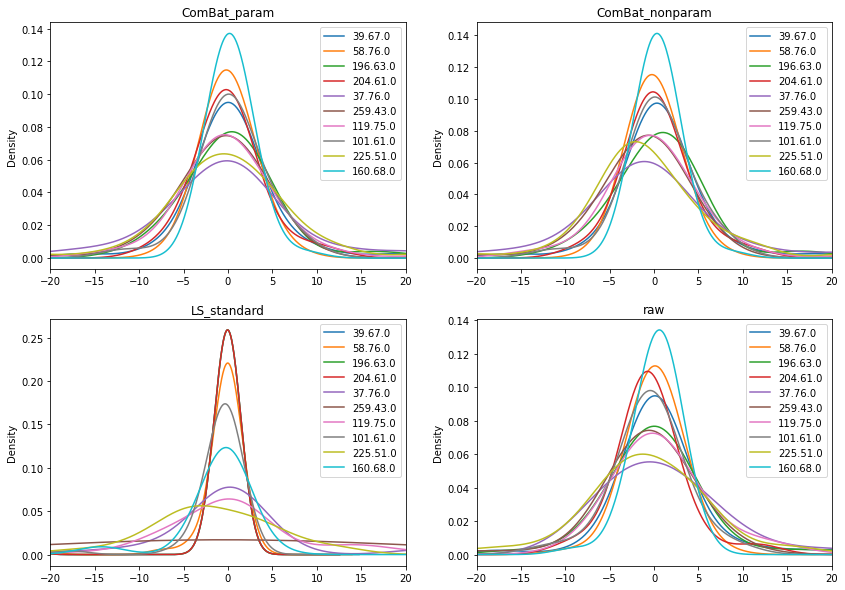

In [24]:
data_set = 'raw' # 'ComBat_param', 'LS_standard', 'raw', 'ComBat_nonparam'
data_type = 'reduced' # original, reduced
axc = 0 # 0: distribution of the mean probe values over the samples, 1: mean sample values over the probes
xr = -20, 20
num_sets = len(data_dict.keys())
fig, ax = plt.subplots(nrows=int(np.ceil(num_sets/2)), ncols=2, figsize=(14,10))
for rdx, _dkey in enumerate(data_dict.keys()):   
    print("Processing ds: {}".format(_dkey))
    for cdx, _batch in enumerate(test_batches):
        #print('Batch: {}'.format(_batch))
        rn = int(np.floor(rdx/2))
        cn = rdx%2
        if data_type == 'original':
            GenX_columns = [_col for _col in data_dict[_dkey].columns if 'GenX_' in _col]
            data_dict[_dkey].query('batch_number=="'+str(_batch)+'"').loc[:,GenX_columns]\
                                                                     .mean(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rn, cn])
        else:
            Red_columns = [_col for _col in data_reduced[_dkey]['ALL']['data'].columns if 'red_' in _col]
            data_reduced[_dkey]['ALL']['data'].query('batch_number=="'+str(_batch)+'"').loc[:,Red_columns]\
                                                                     .mean(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rn, cn])            
        
        ax[rn, cn].set_xlim(xr[0], xr[1])
        ax[rn, cn].set_title(_dkey)
        ax[rn, cn].legend()

In [25]:
batch_list = pheno.batch_number.unique().tolist()

In [26]:
# Sample wise comparison
# get number of batches that are significantly different from the rest
# overall distribution of KS-scores

In [27]:
#key = 'raw'  # 'ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'
red_cols = ['red_'+str(i) for i in range(0, n_components)]
score_list = []
sign_tests = ['ks', 'mwu']
# one-batch v. the rest
def get_sign_test_reduced(data_reduced, batch_list):
    for _test in sign_tests:
        print("Stat test : {}".format(_test))
        for _batch in tqdm(batch_list):
            for _key in data_reduced.keys():
                for idx, _red in enumerate(red_cols):
                    if _test == 'ks':
                        scores = ks2(data1=data_reduced[_key]['ALL']['data'].query("batch_number=='"+str(_batch)+"'").loc[:,_red], 
                           data2=data_reduced[_key]['ALL']['data'].query("batch_number!='"+str(_batch)+"'").loc[:,_red])
                    elif _test =='mwu':
                        scores = mwu(x=data_reduced[_key]['ALL']['data'].query("batch_number=='"+str(_batch)+"'").loc[:,_red], 
                           y=data_reduced[_key]['ALL']['data'].query("batch_number!='"+str(_batch)+"'").loc[:,_red])                
                    score_list.append({'dim': _red, 
                                       'dim_num': idx,
                                       'score': scores[0],
                                       'pval': scores[1], 
                                       'set': _key, 
                                       'test': _test,
                                       'batch': _batch})
    return pd.DataFrame(score_list)

In [29]:
score_df = get_sign_test_reduced(data_reduced, batch_list)

pval_min = 1.
plot_batch = batch_list[7]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

sign_test = 'mwu'  # mw-u
sns.barplot(x='dim', y='score', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'red_5'])) &
                              (score_df.test==sign_test) & 
                              (score_df.pval<pval_min) & 
                              (score_df.batch==plot_batch)], ax=ax[0,0])
sns.lineplot(x='dim_num', y='score', hue='set', 
             data=score_df.loc[(score_df.pval<pval_min)  & 
                               (score_df.test==sign_test) & 
                              (score_df.batch==plot_batch)], ax=ax[0,1])
sns.barplot(x='dim', y='pval', hue='set', 
            data=score_df.loc[(score_df.dim.isin(['red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'red_5'])) &
                              (score_df.test==sign_test) & 
                              (score_df.pval<pval_min) & 
                              (score_df.batch==plot_batch)], ax=ax[1,0])
sns.lineplot(x='dim_num', y='pval', hue='set', 
             data=score_df.loc[(score_df.pval<pval_min)  & 
                               (score_df.test==sign_test) &
                               (score_df.batch==plot_batch)], ax=ax[1,1])
ax[1,1].axhline(0.05, color='black')
fig.suptitle('Separability of batches using {}'.format(sign_test))
plt.show()

  0%|          | 0/43 [00:00<?, ?it/s]

Stat test : ks


 12%|█▏        | 5/43 [00:15<01:58,  3.12s/it]


ValueError: Data passed to ks_2samp must not be empty

In [ ]:
score_df = get_sign_test_reduced(data_reduced, batch_list)

fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df.query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df.query('set=="ComBat_param"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df.query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df.query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df.query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df.query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()


In [ ]:
sign_test = 'mwu'
pval_min = 0.01
dim = 0
dset = 'ComBat_nonparam' # raw, ComBat_param, ComBat_nonparam
# 
(score_df.query('dim_num=='+str(dim)).query('set=="'+dset+'"').query('test=="'+sign_test+'"').pval<pval_min).sum()

Based on KS and MWU tests for each batch-versus-rest the CBC has not incurred a significant change. This could simply mean that there was little cohort-bias to begin with and that the difference is primarily caused by the covariants
and differences in the distribution of the value of interest. Note: cohort bias implies that the cohorts are statistically different over the cohorts, this does not mean that all inter-cohort differences are due to bias. 

We can observe from the PCA-plots that gender is not a strong separator and the cancer type clearly is.

In [30]:
pheno.columns

Index(['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis',
       'Age At Diagnosis (Days)', 'batch_number', 'histological_type',
       'cigarettes_per_day.exposures', 'tissue_or_organ_of_origin.diagnoses',
       'race.demographic'],
      dtype='object')

In [31]:
pheno['Diagnosis_num'] = pheno['Diagnosis'].apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
pheno['Gender_num'] = pheno['Gender'].apply(lambda x: 0 if x=='male' else 1)

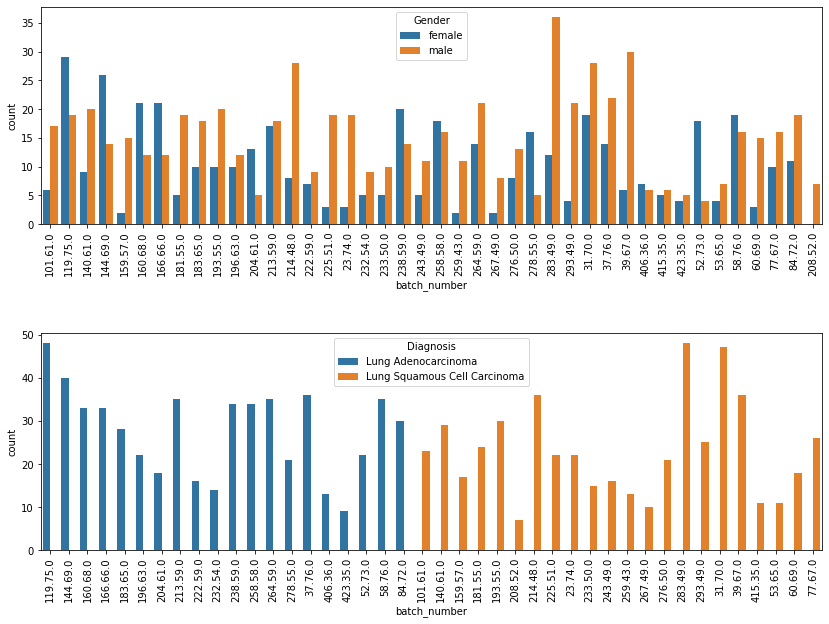

In [32]:
fig, ax = plt.subplots(nrows=2, figsize=(14,10))

pheno_plot = pheno.groupby(['Diagnosis', 'batch_number']).size().reset_index()
pheno_plot.columns=['Diagnosis', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Diagnosis', data=pheno_plot, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

pheno_plot = pheno.groupby(['Gender', 'batch_number']).size().reset_index()
pheno_plot.columns=['Gender', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Gender', data=pheno_plot, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

fig.subplots_adjust(hspace=0.5)

I.e. to perform the batch effect test we should seperate the batches based on the cancer diagnosis.

In [33]:
LA_batches = pheno.query('Diagnosis=="Lung Adenocarcinoma"').batch_number.unique().tolist()
LSCC_batches = pheno.query('Diagnosis=="Lung Squamous Cell Carcinoma"').batch_number.unique().tolist()

In [34]:
score_df_LA = get_sign_test_reduced(data_reduced, LA_batches)


  0%|          | 0/20 [00:00<?, ?it/s]

Stat test : ks


  0%|          | 0/20 [00:00<?, ?it/s]

Stat test : mwu


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


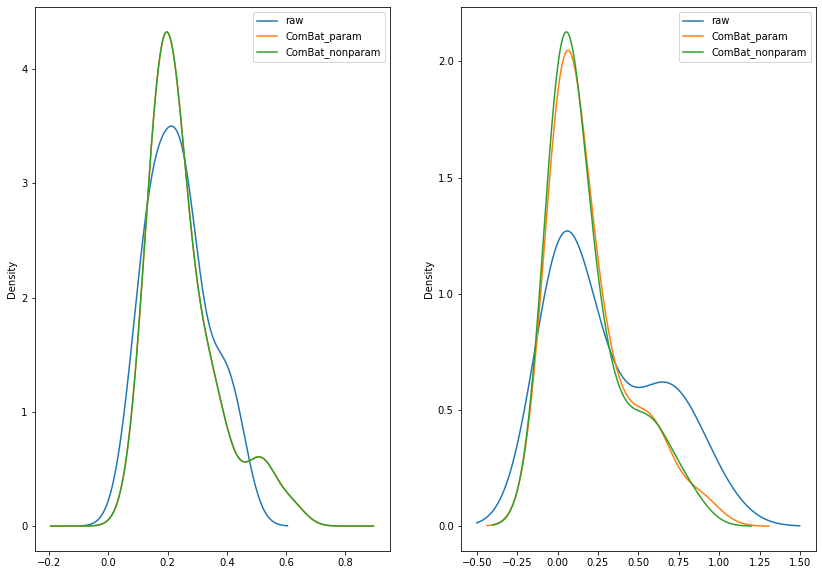

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df_LA.query('dim_num==7').query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df_LA.query('dim_num==7').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df_LA.query('dim_num==7').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df_LA.query('dim_num==7').query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df_LA.query('dim_num==7').query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df_LA.query('dim_num==7').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()

In [39]:
score_df_LSCC = get_sign_test_reduced(data_reduced, LSCC_batches)

  0%|          | 0/22 [00:00<?, ?it/s]

Stat test : ks


  0%|          | 0/22 [00:00<?, ?it/s]

Stat test : mwu


100%|██████████| 22/22 [00:29<00:00,  1.36s/it]


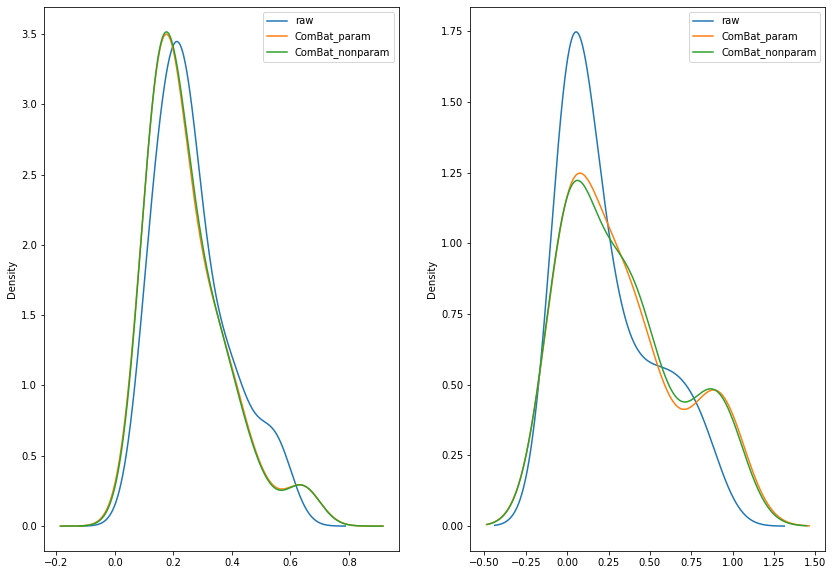

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sign_test = 'ks'
score_df_LSCC.query('dim_num==3').query('set=="raw"').query('test=="'+sign_test+'"').score.plot.kde(label='raw', ax=ax[0])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_param"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_param', ax=ax[0])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').score.plot.kde(label='ComBat_nonparam', ax=ax[0])
#score_df.query('dim_num==0').query('set=="LS_standard"').score.plot.kde(label='LS_standard', ax=ax[0])
ax[0].legend()

score_df_LSCC.query('dim_num==3').query('set=="raw"').query('test=="'+sign_test+'"').pval.plot.kde(label='raw', ax=ax[1])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_param"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_param', ax=ax[1])
score_df_LSCC.query('dim_num==3').query('set=="ComBat_nonparam"').query('test=="'+sign_test+'"').pval.plot.kde(label='ComBat_nonparam', ax=ax[1])
#score_df.query('dim_num==0').query('set=="LS_standard"').pval.plot.kde(label='LS_standard', ax=ax[1])
ax[1].legend()

Concluding, the CBC has only affected a few batches (most notably in the first, third, fourth and fifth principal components) that contain Lung Adenocarcinoma samples and has not significantly reduced the separability of the cancer types.

In [ ]:
data_dict.keys()

In [35]:
class fs_mannwhitney():
    pvalue = 0.01
    p_values = None

    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        _, p_value = mannwhitneyu(pos[:,column], neg[:,column], alternative="less")
        return p_value

    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.p_values = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

In [36]:
def get_filtered_genomes(x, y, Rclass = None):
    try:
        alpha = Rclass.PIPELINE_PARAMETERS['feature_selection']['pvalue']
        filter_type = Rclass.PIPELINE_PARAMETERS['feature_selection']['method']
        F_function =  Rclass.PIPELINE_PARAMETERS['feature_selection']['score_function']
    except Exception as e:
        print("Exception with {} handling the function get_filtered_genomes".format(e))
        alpha = 0.05
        filter_type = 'FDR'
        F_function = 'ANOVA'    
    
    #  Mann-Whitney, between classes
    # scipy.stats.mannwhitneyu, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    if filter_type == 'mannwhitney':
        Selector = fs_mannwhitney(pvalue = alpha).fit(x,y)
        x_out = Selector.transform(x)[0]
    elif filter_type == 'FDR':
    # Use FDR with a number of different statistical measures:
    # f_classif, chi2, 
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(alpha = alpha, score_func = FDR_function) #f_classif, chi2
        Selector = FDR.fit(x, y)
        x_out = FDR.transform(x)
    elif filter_type == 'FPR':
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFpr(alpha = alpha, score_func = FPR_function) #f_classif, chi2
        Selector = FPR.fit(x, y)
        x_out = FPR.transform(x)        

    return x_out, Selector

In [37]:
#@jit('int32[:](float64[:,:], int32[:]))
from sklearn.feature_selection import SelectFdr, SelectFpr
from sklearn.feature_selection import f_classif, chi2
def get_differential_probes(x, y,  method='FDR', n_top = 10, **kwargs):
    '''
     x : array (samples x probes)
     y : array (target values)
     method : FDR/MWU/KS 
     n_top : number of top discriminating probes 
     kwargs: arguments for stat method
     
     return: index array of top n discriminators
    '''
    alpha=0.01
    F_function = 'ANOVA'
    FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
    FDR = SelectFdr(alpha = alpha, score_func = FDR_function) #f_classif, chi2
    selector = FDR.fit(x, y)
       
    return pd.DataFrame(data=np.vstack((selector.pvalues_, selector.scores_)).T, columns=['pvals', 'score'])
    return selector

In [41]:
genx_cols = [_col for _col in data_dict['raw'].columns if 'GenX' in _col]
y = data_dict['raw']['Diagnosis'].apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
x = data_dict['raw'].loc[:,genx_cols].values

probes_diffs = get_differential_probes(x, y, method='FDR', n_top=10)
probes_diffs.index = data_dict['raw'].loc[:,genx_cols].columns

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 2202  2222  2235 ... 60471 60472 60473] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [57]:
probes_diffs2 = get_differential_probes(x, y, method='mannwhitney', n_top=10)
probes_diffs2.index = data_dict['raw'].loc[:,genx_cols].columns

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 2202  2222  2235 ... 60471 60472 60473] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [54]:
q95=probes_diffs.score.quantile(0.95)
top_probes = probes_diffs.query("pvals<0.0001").query("score>"+str(q95)).sort_values('score', ascending=False)

In [80]:
top_probes[:8]

,pvals,score
GenX_KRT5.chr12.52514575.52520687.-,0.000000e+00,3401.525390
GenX_DSC3.chr18.30990008.31042815.-,1.481053e-298,2794.522270
GenX_DSG3.chr18.31447795.31478702.+,2.274638e-295,2741.297601
GenX_TP63.chr3.189631416.189897279.+,7.038313e-272,2370.989336
GenX_MIR205HG.chr1.209428820.209432838.+,1.750654e-258,2176.241941
GenX_CALML3.chr10.5524009.5526771.+,4.687111e-248,2032.348768
GenX_KRT6A.chr12.52487174.52493257.-,2.385208e-247,2022.833434
GenX_PVRL1.chr11.119623408.119729084.-,2.930202e-247,2021.632058


In [62]:
[_col for _col in data_dict['raw'].columns.tolist() if 'MIR205' in _col]

['GenX_MIR205HG.chr1.209428820.209432838.+',
 'GenX_MIR2053.chr8.112643493.112643583.+',
 'GenX_MIR205.chr1.209432133.209432242.+']

Text(0.5, 1.0, 'Top cancer genes with/without bias correction')

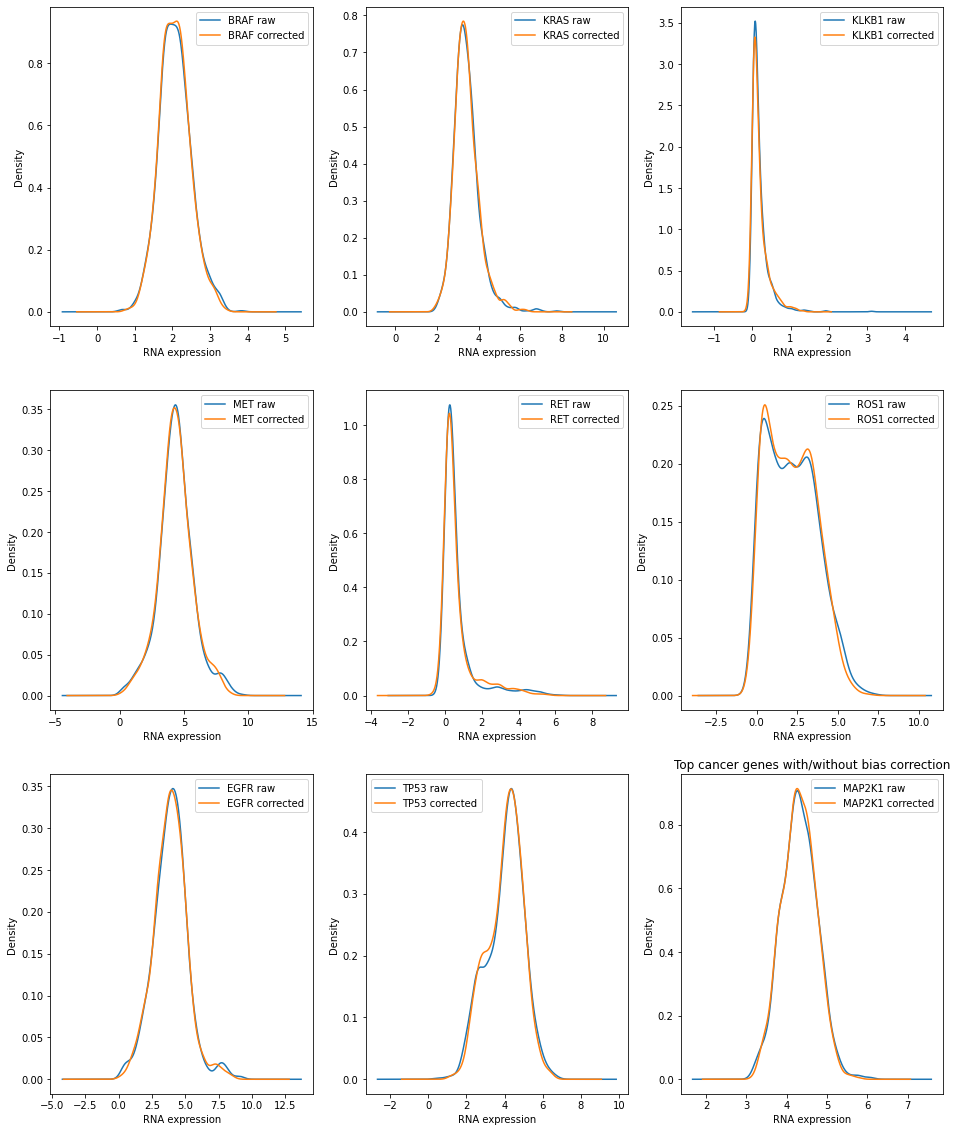

In [63]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(16, 20))


data_dict['raw']['GenX_BRAF.chr7.140719327.140924764.-'].plot.kde(ax=ax[0,0], 
                                                                  label='BRAF raw') # 
data_dict['ComBat_nonparam']['GenX_BRAF.chr7.140719327.140924764.-'].plot.kde(ax=ax[0,0], 
                                                                              label='BRAF corrected')

data_dict['raw']['GenX_KRAS.chr12.25204789.25250936.-'].plot.kde(ax=ax[0,1], label='KRAS raw') # 
data_dict['ComBat_nonparam']['GenX_KRAS.chr12.25204789.25250936.-'].plot.kde(ax=ax[0,1], 
                                                                             label='KRAS corrected')

data_dict['raw']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde(ax=ax[0,2], label='KLKB1 raw') # 
data_dict['ComBat_nonparam']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde(ax=ax[0,2],
                                                                               label='KLKB1 corrected')

data_dict['raw']['GenX_MET.chr7.116672390.116798386.+'].plot.kde(ax=ax[1,0], 
                                                                 label='MET raw') # 
data_dict['ComBat_nonparam']['GenX_MET.chr7.116672390.116798386.+'].plot.kde(ax=ax[1,0], 
                                                                             label='MET corrected')

data_dict['raw']['GenX_RET.chr10.43077027.43130351.+'].plot.kde(ax=ax[1,1], label='RET raw') # 
data_dict['ComBat_nonparam']['GenX_RET.chr10.43077027.43130351.+'].plot.kde(ax=ax[1,1], 
                                                                            label='RET corrected')

data_dict['raw']['GenX_ROS1.chr6.117288300.117425855.-'].plot.kde(ax=ax[1,2], label='ROS1 raw') # 
data_dict['ComBat_nonparam']['GenX_ROS1.chr6.117288300.117425855.-'].plot.kde(ax=ax[1,2], 
                                                                              label='ROS1 corrected')

data_dict['raw']['GenX_EGFR.chr7.55019021.55256620.+'].plot.kde(ax=ax[2,0], label='EGFR raw') # 
data_dict['ComBat_nonparam']['GenX_EGFR.chr7.55019021.55256620.+'].plot.kde(ax=ax[2,0], 
                                                                            label='EGFR corrected')

data_dict['raw']['GenX_TP53.chr17.7661779.7687550.-'].plot.kde(ax=ax[2,1], label='TP53 raw') # 
data_dict['ComBat_nonparam']['GenX_TP53.chr17.7661779.7687550.-'].plot.kde(ax=ax[2,1], 
                                                                           label='TP53 corrected')

data_dict['raw']['GenX_MAP2K1.chr15.66386817.66492312.+'].plot.kde(ax=ax[2,2], label='MAP2K1 raw') # 
data_dict['ComBat_nonparam']['GenX_MAP2K1.chr15.66386817.66492312.+'].plot.kde(ax=ax[2,2], 
                                                                               label='MAP2K1 corrected')

ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,2].legend()
ax[2,0].legend()
ax[2,1].legend()
ax[2,2].legend()

ax[0,0].set_xlabel('RNA expression')
ax[0,1].set_xlabel('RNA expression')
ax[0,2].set_xlabel('RNA expression')
ax[1,0].set_xlabel('RNA expression')
ax[1,1].set_xlabel('RNA expression')
ax[1,2].set_xlabel('RNA expression')
ax[2,0].set_xlabel('RNA expression')
ax[2,1].set_xlabel('RNA expression')
ax[2,2].set_xlabel('RNA expression')

plt.title("Top cancer genes with/without bias correction")

Text(0.5, 1.0, 'Top differential genes with/without bias correction')

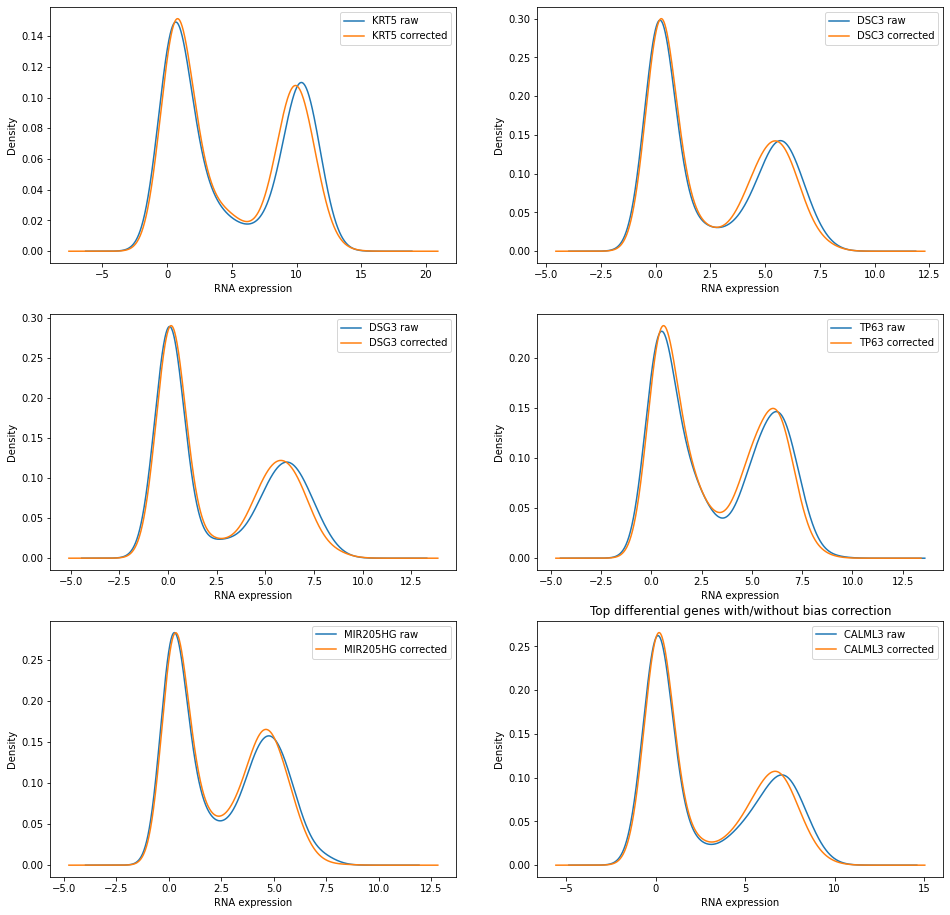

In [64]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(16, 16))


data_dict['raw']['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(ax=ax[0,0], 
                                                                  label='KRT5 raw') # 
data_dict['ComBat_nonparam']['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(ax=ax[0,0], 
                                                                              label='KRT5 corrected')

data_dict['raw']['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde(ax=ax[0,1], label='DSC3 raw') # 
data_dict['ComBat_nonparam']['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde(ax=ax[0,1], 
                                                                             label='DSC3 corrected')

data_dict['raw']['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde(ax=ax[1,0], label='DSG3 raw') # 
data_dict['ComBat_nonparam']['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde(ax=ax[1,0],
                                                                               label='DSG3 corrected')

data_dict['raw']['GenX_TP63.chr3.189631416.189897279.+'].plot.kde(ax=ax[1,1], 
                                                                 label='TP63 raw') # 
data_dict['ComBat_nonparam']['GenX_TP63.chr3.189631416.189897279.+'].plot.kde(ax=ax[1,1], 
                                                                             label='TP63 corrected')

data_dict['raw']['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde(ax=ax[2,0], label='MIR205HG raw') # 
data_dict['ComBat_nonparam']['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde(ax=ax[2,0], 
                                                                            label='MIR205HG corrected')

data_dict['raw']['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde(ax=ax[2,1], label='CALML3 raw') # 
data_dict['ComBat_nonparam']['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde(ax=ax[2,1], 
                                                                              label='CALML3 corrected')

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[2,0].legend()
ax[2,1].legend()

ax[0,0].set_xlabel('RNA expression')
ax[0,1].set_xlabel('RNA expression')
ax[1,0].set_xlabel('RNA expression')
ax[1,1].set_xlabel('RNA expression')
ax[2,0].set_xlabel('RNA expression')
ax[2,1].set_xlabel('RNA expression')

plt.title("Top differential genes with/without bias correction")

In [65]:
from matplotlib.lines import Line2D
Line2D.markers

{'.': 'point',
 ',': 'pixel',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 '1': 'tri_down',
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond',
 'd': 'thin_diamond',
 '|': 'vline',
 '_': 'hline',
 'P': 'plus_filled',
 'X': 'x_filled',
 0: 'tickleft',
 1: 'tickright',
 2: 'tickup',
 3: 'tickdown',
 4: 'caretleft',
 5: 'caretright',
 6: 'caretup',
 7: 'caretdown',
 8: 'caretleftbase',
 9: 'caretrightbase',
 10: 'caretupbase',
 11: 'caretdownbase',
 'None': 'nothing',
 None: 'nothing',
 ' ': 'nothing',
 '': 'nothing'}

Text(0.5, 1.0, 'Top differential cancer genes')

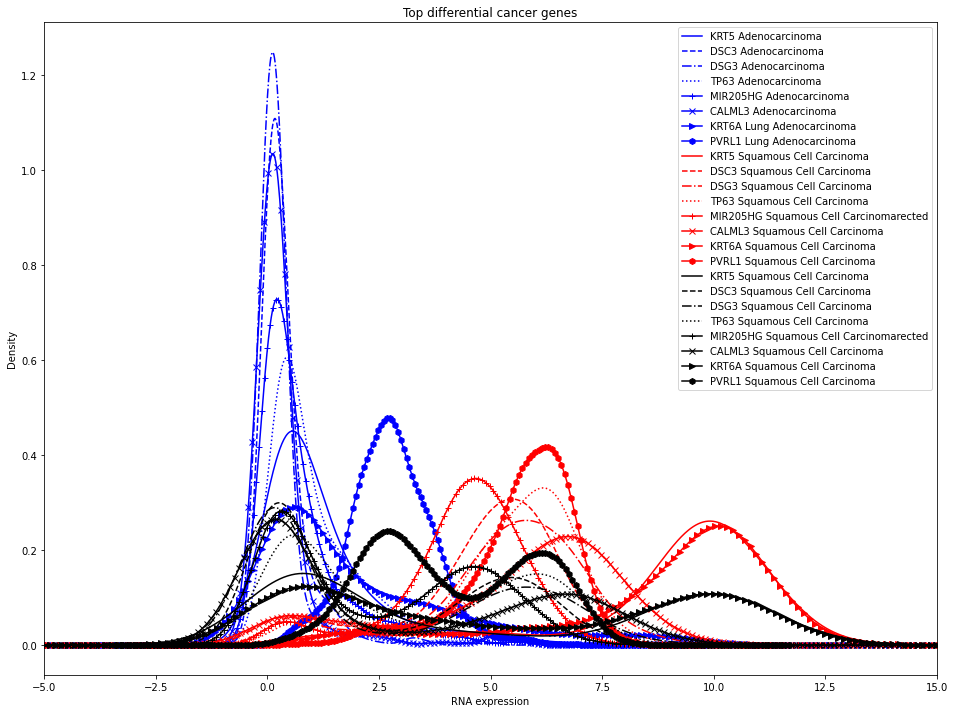

In [278]:
data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(figsize=(16,12), color='blue', 
                                                         label='KRT5 Adenocarcinoma',
                                                         style="-")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde( color='blue',
                                                         label='DSC3 Adenocarcinoma',
                                                         style="--")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde( color='blue',
                                                         label='DSG3 Adenocarcinoma',
                                                         style="-.")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_TP63.chr3.189631416.189897279.+'].plot.kde( color='blue',
                                                          label='TP63 Adenocarcinoma',
                                                         style=":")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde( color='blue',
                                                              label='MIR205HG Adenocarcinoma',
                                                              marker="+",
                                                              markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde( color='blue',
                                                         label='CALML3 Adenocarcinoma',
                                                         marker="x",
                                                         markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_KRT6A.chr12.52487174.52493257.-'].plot.kde( color='blue',
                                                         label='KRT6A Lung Adenocarcinoma',
                                                         marker='>',
                                                         markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_PVRL1.chr11.119623408.119729084.-'].plot.kde( color='blue',
                                                         label='PVRL1 Lung Adenocarcinoma',
                                                         marker='h',
                                                         markevery=5)



data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(figsize=(16,12), color='red', 
                                                         label='KRT5 Squamous Cell Carcinoma',
                                                         style="-")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde( color='red',
                                                         label='DSC3 Squamous Cell Carcinoma',
                                                         style="--")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde( color='red',
                                                         label='DSG3 Squamous Cell Carcinoma',
                                                         style="-.")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_TP63.chr3.189631416.189897279.+'].plot.kde( color='red',
                                                          label='TP63 Squamous Cell Carcinoma',
                                                         style=":")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde( color='red',
                                                              label='MIR205HG Squamous Cell Carcinomarected',
                                                             marker='+',
                                                             markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde( color='red',
                                                         label='CALML3 Squamous Cell Carcinoma',
                                                         marker='x',
                                                         markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_KRT6A.chr12.52487174.52493257.-'].plot.kde( color='red',
                                                         label='KRT6A Squamous Cell Carcinoma',
                                                         marker='>',
                                                         markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_PVRL1.chr11.119623408.119729084.-'].plot.kde( color='red',
                                                         label='PVRL1 Squamous Cell Carcinoma',
                                                         marker='h',
                                                         markevery=5)

############


data_dict['ComBat_nonparam']['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(figsize=(16,12), color='black', 
                                                         label='KRT5',
                                                         style="-")

data_dict['ComBat_nonparam']['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde( color='black',
                                                         label='DSC3',
                                                         style="--")

data_dict['ComBat_nonparam']['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde( color='black',
                                                         label='DSG3',
                                                         style="-.")

data_dict['ComBat_nonparam']['GenX_TP63.chr3.189631416.189897279.+'].plot.kde( color='black',
                                                          label='TP63',
                                                         style=":")

data_dict['ComBat_nonparam']['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde( color='black',
                                                              label='MIR205HG',
                                                             marker='+',
                                                             markevery=5)

data_dict['ComBat_nonparam']['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde( color='black',
                                                         label='CALML3',
                                                         marker='x',
                                                         markevery=5)

data_dict['ComBat_nonparam']['GenX_KRT6A.chr12.52487174.52493257.-'].plot.kde( color='black',
                                                         label='KRT6A',
                                                         marker='>',
                                                         markevery=5)

data_dict['ComBat_nonparam']['GenX_PVRL1.chr11.119623408.119729084.-'].plot.kde( color='black',
                                                         label='PVRL1,
                                                         marker='h',
                                                         markevery=5)

plt.xlim(-5,15)
plt.xlabel('RNA expression')
plt.legend()
plt.title("Top differential cancer genes")

From the distributions above you can clearly see that the two lung cancer diagnoses can be seperated by these six genes.

In [212]:
top_100 = top_probes[:100].index.tolist()

In [260]:
sep_list = top_100

In [261]:
# NOT FOR GENERIC SEP LISTS
lscc_appr = data_dict['ComBat_nonparam'].loc[(data_dict['ComBat_nonparam'][sep_list[0]]>2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[1]]>2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[2]]>2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[3]]>2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[4]]>2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[5]]>2.5), 
                                             'Diagnosis'].value_counts()
la_appr = data_dict['ComBat_nonparam'].loc[(data_dict['ComBat_nonparam'][sep_list[0]]<2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[1]]<2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[2]]<2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[3]]<2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[4]]<2.5) &
                                 (data_dict['ComBat_nonparam'][sep_list[5]]<2.5),
                                           'Diagnosis'].value_counts()


In [394]:
from scipy.optimize import differential_evolution as de
def _sep_opt(v, x=data_dict['ComBat_nonparam'], opt=True):
    
    boolean_operator_p = np.ones((x.shape[0],), dtype=bool)
    for idx, _t in enumerate(sep_list):
        boolean_operator_p *= x[_t]>v[idx]
        
    boolean_operator_n = np.ones((x.shape[0],), dtype=bool)
    for idx, _t in enumerate(sep_list):
        boolean_operator_n *= x[_t]<v[idx]
                
    
    lscc_appr = x.loc[boolean_operator_p,'Diagnosis'].value_counts()
    la_appr = x.loc[boolean_operator_n,'Diagnosis'].value_counts()    
    
    prec_lscc = lscc_appr[0]/lscc_appr.sum()
    prec_la = la_appr[0]/la_appr.sum()
    recall_lscc = lscc_appr[0]/504
    recall_la = la_appr[0]/549
    f1_lscc = 2/(1/recall_lscc + 1/prec_lscc)
    f1_la = 2/(1/recall_la+ 1/prec_la)
    mean_f1 = (f1_lscc+f1_la)/2
    
    if opt==False:
        return {'prec_lscc': prec_lscc, 
                'prec_la': prec_la, 
                'recall_lscc': recall_lscc,
                'recall_la': recall_la,
                'f1_lscc': f1_lscc, 
                'f1_la': f1_la}
    else:
        return -mean_f1
    
def _sep_opt_np(v, x=None, y=None, direction=None, opt=True, eps=1e-5):
    boolean_operator_p = np.ones((x.shape[0],), dtype=bool)
    for idx in range(0, len(v)):
        _cond = x[:, idx]>v[idx]
        boolean_operator_p *=  _cond if direction[idx] else np.invert(_cond)

    boolean_operator_n = np.ones((x.shape[0],), dtype=bool)
    for idx in range(0, len(v)):
        _cond = x[:, idx]<v[idx]
        boolean_operator_n *= _cond if direction[idx] else np.invert(_cond)
        
    lscc_appr = y[np.where(boolean_operator_p)]
    la_appr = y[np.where(boolean_operator_n)]  
     
    
    prec_lscc = sum(lscc_appr)/lscc_appr.shape[0]
    prec_la = sum(la_appr)/la_appr.shape[0]
    recall_lscc = sum(lscc_appr)/504
    recall_la = sum(la_appr==0)/549
    f1_lscc = 2/(1/(recall_lscc+eps) + 1/(prec_lscc+eps))
    f1_la = 2/(1/(recall_la+eps)+ 1/(prec_la+eps))
    mean_f1 = (f1_lscc+f1_la)/2
    
    if opt==False:
        return {'prec_lscc': prec_lscc,
                'prec_la': prec_la,
                'recall_lscc': recall_lscc,
                'recall_la': recall_la,
                'f1_lscc': f1_lscc,
                'f1_la': f1_la}
    else:
        return -mean_f1

In [372]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit as sss
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score, recall_score, precision_score, average_precision_score

In [373]:
data_dict['ComBat_nonparam'].dropna(subset=['Diagnosis'], axis=0, inplace=True)
diag_map = {'Lung Adenocarcinoma': 0, 'Lung Squamous Cell Carcinoma': 1}

In [374]:
genx_cols = [_col for _col in data_dict['ComBat_nonparam'].columns if 'GenX' in _col]
X = data_dict['ComBat_nonparam'].loc[:,sep_list].values
Y = data_dict['ComBat_nonparam']['Diagnosis'].map(diag_map).values

In [375]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, train_size=0.8)

In [376]:
def simple_model(X, coeffs, direction):
    boolean_operator_p = np.ones((X.shape[0],), dtype=bool)
    for idx in range(0, len(coeffs)):
        _cond = X[:, idx]>coeffs[idx]
        boolean_operator_p *= _cond if direction[idx] else np.invert(_cond)

    boolean_operator_n = np.ones((X.shape[0],), dtype=bool)
    for idx in range(0, len(coeffs)):
        _cond = X[:, idx]<coeffs[idx]
        boolean_operator_n *= _cond if direction[idx] else np.invert(_cond) 
        
    y_estimate = np.zeros((X.shape[0], ))    
    y_estimate[:] = -1  
    
    y_estimate[np.where(boolean_operator_p)] = 1    
    y_estimate[np.where(boolean_operator_n)] = 0
    
    return y_estimate

In [392]:
def run_model(X,Y, n_splits=20, random_state=322, make_plot=False, num_top=5):
    splitter = sss(n_splits=20, random_state=random_state)
    res_list=[]
    for train_index, test_index in splitter.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # optimize for coefficients
        res = de(_sep_opt_np, 
                 bounds=rtup_list[:num_top], 
                 args=(X_train, y_train, sign_list),
                 maxiter=250,
                 popsize=10, 
                 tol=0.05, 
                 mutation=(0.6, 0.99), 
                 recombination=0.4)

        y_pred = simple_model(X_test, res.x, sign_list)

        f1 = f1_score(y_pred[np.where(y_pred>-1)], y_test[np.where(y_pred>-1)])
        auc = roc_auc_score(y_pred[np.where(y_pred>-1)], y_test[np.where(y_pred>-1)])
        prec = precision_score(y_pred[np.where(y_pred>-1)], y_test[np.where(y_pred>-1)])
        acc = balanced_accuracy_score(y_pred[np.where(y_pred>-1)], y_test[np.where(y_pred>-1)])
        aps = average_precision_score(y_pred[np.where(y_pred>-1)], y_test[np.where(y_pred>-1)])
        recall_pos = np.where((y_pred==1) & (y_test==1))[0].shape[0]/np.sum(y_test==1) 
        recall_neg = np.where((y_pred==0) & (y_test==0))[0].shape[0]/np.sum(y_test==0) 

        res_list.append({'F1': f1, 'AUC': auc, 'PREC': prec, 'ACC': acc, 
                         'recall_squamouscell': recall_pos, 'recall_adeno': recall_neg,
                         'average-precision': aps})

    res_list_df = pd.DataFrame(res_list)

    if make_plot:
        fig, ax = plt.subplots(figsize=(14,7))
        sns.boxplot(data=pd.melt(res_list_df), x='variable', y='value', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
        
    return res_list_df

In [414]:
# want to set the rtup to (median-dev, median+dev)
max_genes = 25
dev_max = 0.1

sign_list = []
for jdx, _term in enumerate(sep_list):
    _sign = np.median(X[np.where(Y==1),jdx])>np.median(X[np.where(Y==0),jdx])
    sign_list.append(_sign)
    
rtup_list = []
for jdx, _term in enumerate(sep_list):
    _med = np.median(X[:, jdx])
    _dev = np.std(X[:, jdx])
    _dev = dev_max if _dev>dev_max else _dev
    rtup_list.append((_med-_dev, _med+_dev))
    
results_list = []
for c in range(1, max_genes):
    res_df_tmp = run_model(X,Y, n_splits=20, random_state=322, make_plot=False, num_top=c)
    res_df_tmp['num_genes'] = c
    if c>1:
        res_df = pd.concat([res_df, res_df_tmp], axis=0)
    else:
        res_df = res_df_tmp

In [415]:
res_df

,F1,AUC,PREC,ACC,recall_squamouscell,recall_adeno,average-precision,num_genes
0,0.925926,0.928392,0.980392,0.928392,0.980392,0.872727,0.926031,1
1,0.903846,0.905660,0.921569,0.905660,0.921569,0.890909,0.873844,1
2,0.932039,0.933761,0.941176,0.933761,0.941176,0.927273,0.906514,1
3,0.921569,0.924421,0.921569,0.924421,0.921569,0.927273,0.887025,1
4,0.930693,0.934286,0.921569,0.934286,0.921569,0.945455,0.894576,1
...,...,...,...,...,...,...,...,...
15,1.000000,1.000000,1.000000,1.000000,0.705882,0.145455,1.000000,24
16,1.000000,1.000000,1.000000,1.000000,0.705882,0.163636,1.000000,24
17,0.986301,0.986486,1.000000,0.986486,0.705882,0.272727,0.992204,24
18,1.000000,1.000000,1.000000,1.000000,0.784314,0.127273,1.000000,24


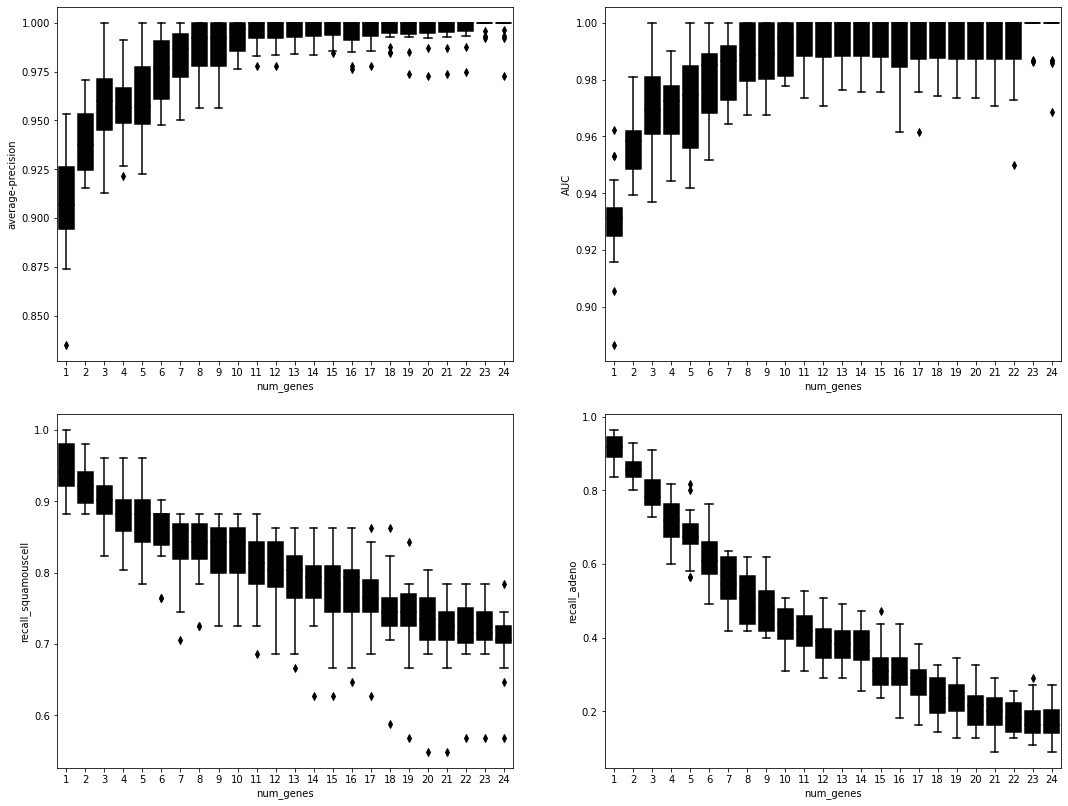

In [418]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,14))
sns.boxplot(data=res_df, x='num_genes', y='average-precision', color='black', ax=ax[0,0]) 
sns.boxplot(data=res_df, x='num_genes', y='AUC', color='black', ax=ax[0,1]) 
sns.boxplot(data=res_df, x='num_genes', y='recall_squamouscell', color='black', ax=ax[1,0]) 
sns.boxplot(data=res_df, x='num_genes', y='recall_adeno', color='black', ax=ax[1,1]) 
plt.subplots_adjust(hspace=0.15)

If we simplistically take an RNA-expression value of $2.5$ as the seperator between LA/LSCC we get the following estimates: 

|               | LSCC actual |  LA actual |
|---	        |---	      |---         |
|  LSCC pred 	|  **384** 	  |   19 	   |
|  LA pred   	|    2 	   	  |   **404**  |

With the following scores:

|   	    | recall   	    |  precision  | F1 score  |
|---	    |---	        |---          |---  |
|  LSCC  	|  $76\%$  	  	|   $99\%$    | $0.86$|
|  LA    	|  $74\%$ 	    |   $95\%$    | $0.83$|

With a total actual LSCC, LA of $504$ and $549$ respectively 

The high number of dimensions with respect to the number of samples opens up the question whether or not the seperations are fortuitous (e.g. random) or actually meaningful.
We have about $60.000$ dimensions and about $900$ samples, i.e. the dimension/sample ratio is about $60:1$. The question is: how likely is it that
along $1$ dimension the $900$ samples are seperated evenly and correctly in two classes?

Given a random distribution of the two classes over $900$ samples. The probability that for a particular
dimension there is a correct distinction between two classes over $M$ samples is roughly $\propto \rho^M$ where $M$ is the number of samples and $\rho$ is 
the prior probability of class A (where the proba for class B is $1-\rho$). This amounts to a negligible probability of a correct random assignment
for one dimension, let alone for $6$ dimensions. 

## Intra-cohort and inter-cohort median


median shift distribution: $\Delta median$

In [19]:
data_dict['raw'].Diagnosis.unique()

array(['Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma', nan],
      dtype=object)

In [20]:
x_dict = {}
x_dict['LA'] = data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Adenocarcinoma', genx_cols].values
x_dict['LSCC'] = data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Squamous Cell Carcinoma', genx_cols].values

batches_dict = {}
batches_dict['LA'] = np.array(data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Adenocarcinoma']\
                              .batch_number.unique().tolist())
batches_dict['LA'] = batches_dict['LA'][batches_dict['LA']!='nan']

batches_dict['LSCC'] = np.array(data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Squamous Cell Carcinoma']\
                                .batch_number.unique().tolist())
batches_dict['LSCC'] = batches_dict['LSCC'][batches_dict['LSCC']!='nan']

In [21]:
index_map={}
index_map['raw'] = data_dict['raw'].reset_index()[['index']]
data_dict['raw'] = data_dict['raw'].reset_index().drop('index', axis=1)

In [22]:
names = {'LA': 'Lung Adenocarcinoma',
         'LSCC': 'Lung Squamous Cell Carcinoma'}

In [23]:
batch_dict = {}
sample_ids = data_dict['raw'].index.values

for _ds in batches_dict.keys():
    batches = batches_dict[_ds]
    batch_dict[_ds] = {} 
    ds = data_dict['raw'].query('Diagnosis=="'+names[_ds]+'"').reset_index()
    for _batch in batches:
        batch_dict[_ds][_batch] = ds.query('batch_number=="'+str(_batch)+'"').index.values

batch_dict_all = {}
for _ds in batches_dict.keys():
    batches = batches_dict[_ds]
    batch_dict_all[_ds] = {} 
    ds = data_dict['raw'].query('Diagnosis=="'+names[_ds]+'"')
    for _batch in batches:
        batch_dict_all[_ds][_batch] = ds.query('batch_number=="'+str(_batch)+'"').index.values

In [684]:
median_shifts = {}
median_shifts['raw'] = {'LA': median_shift(x_dict['LA'].T, batch_dict['LA'])}
median_shifts['raw']['LSCC'] =  median_shift(x_dict['LSCC'].T, batch_dict['LSCC'])

mean_shifts = {}
mean_shifts['raw'] = {'LA': mean_shift(x_dict['LA'].T, batch_dict['LA'])}
mean_shifts['raw']['LSCC'] = mean_shift(x_dict['LSCC'].T, batch_dict['LSCC'])


20it [00:19,  1.01it/s]
22it [00:18,  1.16it/s]
20it [00:08,  2.38it/s]
22it [00:08,  2.71it/s]


Text(0.5,0.98,'Original uncorrected data, RNA expression')

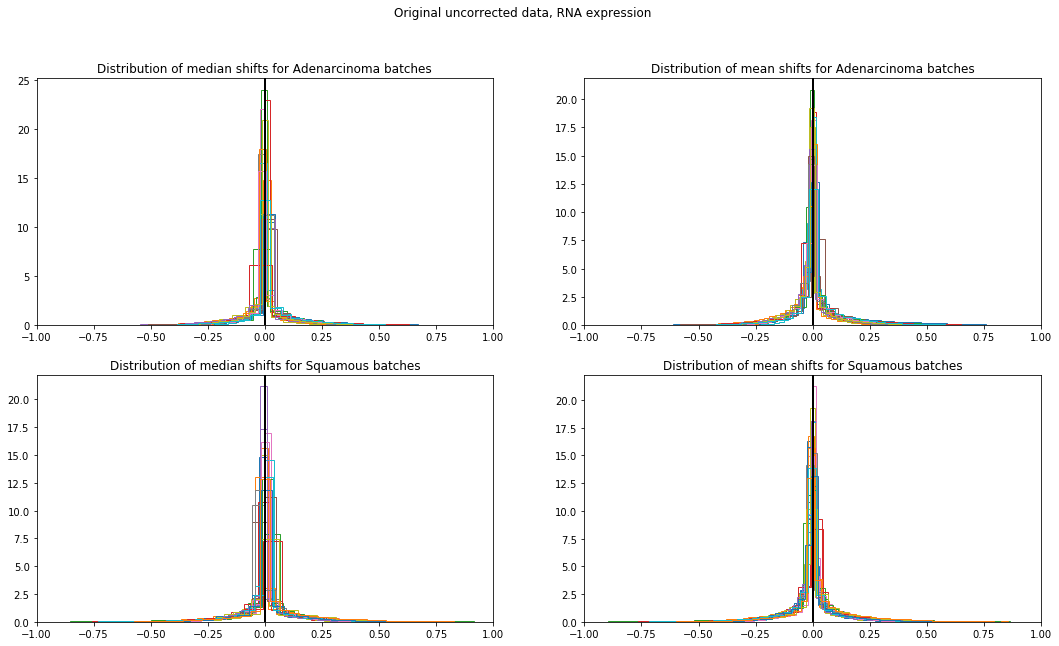

In [738]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,10))

for i in range(0,median_shifts['raw']['LA'].shape[1]):
    ax[0,0].hist(median_shifts['raw']['LA'][:,i], bins=120, histtype='step', density=True);
    ax[0,0].set_xlim(-1,1)
    ax[0,0].axvline(0,color='black')
    ax[0,0].set_title('Distribution of median shifts for Adenarcinoma batches')
    
for i in range(0,median_shifts['raw']['LA'].shape[1]):
    ax[0,1].hist(mean_shifts['raw']['LA'][:,i], bins=120, histtype='step', density=True);    
    ax[0,1].set_xlim(-1,1)
    ax[0,1].axvline(0,color='black')
    ax[0,1].set_title('Distribution of mean shifts for Adenarcinoma batches')
    
for i in range(0,median_shifts['raw']['LSCC'].shape[1]):
    ax[1,0].hist(median_shifts['raw']['LSCC'][:,i], bins=120, histtype='step', density=True);
    ax[1,0].set_xlim(-1,1)
    ax[1,0].axvline(0,color='black')
    ax[1,0].set_title('Distribution of median shifts for Squamous batches')
    
for i in range(0,median_shifts['raw']['LSCC'].shape[1]):
    ax[1,1].hist(mean_shifts['raw']['LSCC'][:,i], bins=120, histtype='step', density=True);    
    ax[1,1].set_xlim(-1,1)
    ax[1,1].axvline(0,color='black')
    ax[1,1].set_title('Distribution of mean shifts for Squamous batches')
    
plt.suptitle('Original uncorrected data, RNA expression')


The probe medians and means do not appear to be shifted significantly between the batches.

# Probewise similarity

Paired similarity measures are
* Kullback-Leibler divergence
* cosine distance (or any other vectorial similarity such as the Euclidian distance)

Unpaired similarity measures are
* Wasserstein distances (1st is Earth Mover Distance, 2nd is energy distance)
* Mann-Whitney U
* Kolmogorov-Smirnov
* Anderson-Darling (tests for normality)
* Cramér-Von Mises (tests for normality)
* Cramér distance

We can determine and compare the intra-cohort similarities and the inter-cohort similarities.

In [951]:
#import importlib
#print(pd.__version__)
#importlib.reload(pd.core)

In [34]:
import matplotlib.pyplot as plt

euclid = lambda x1, x2: sc.spatial.distance.euclidean(x1, x2)
cosine = lambda x1, x2: sc.spatial.distance.cosine(x1, x2)
correl = lambda x1, x2: sc.spatial.distance.correlation(x1, x2)
pearsonrl = lambda x1, x2: sc.stats.pearsonr(x1, x2)

IndTuple = tuple([_batch for _batch in batch_dict_all['LA'].values()])
combo_list = np.hstack(IndTuple)
corr_sub_LA = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all_LA = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)

IndTuple = tuple([_batch for _batch in batch_dict_all['LSCC'].values()])
combo_list = np.hstack(IndTuple)
corr_sub_LSCC = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all_LSCC = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)


In [109]:
IndTuple_LSCC = tuple([_batch for _batch in batch_dict_all['LSCC'].values()])
IndTuple_LA = tuple([_batch for _batch in batch_dict_all['LA'].values()])

combo_list_LSCC = np.hstack(IndTuple_LSCC)
combo_list_LA = np.hstack(IndTuple_LA)
combo_list = np.hstack((combo_list_LSCC,combo_list_LA))

corr_sub = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)

Text(0.5,0.98,'Patient correlations, left block is LSCC, right block is LA')

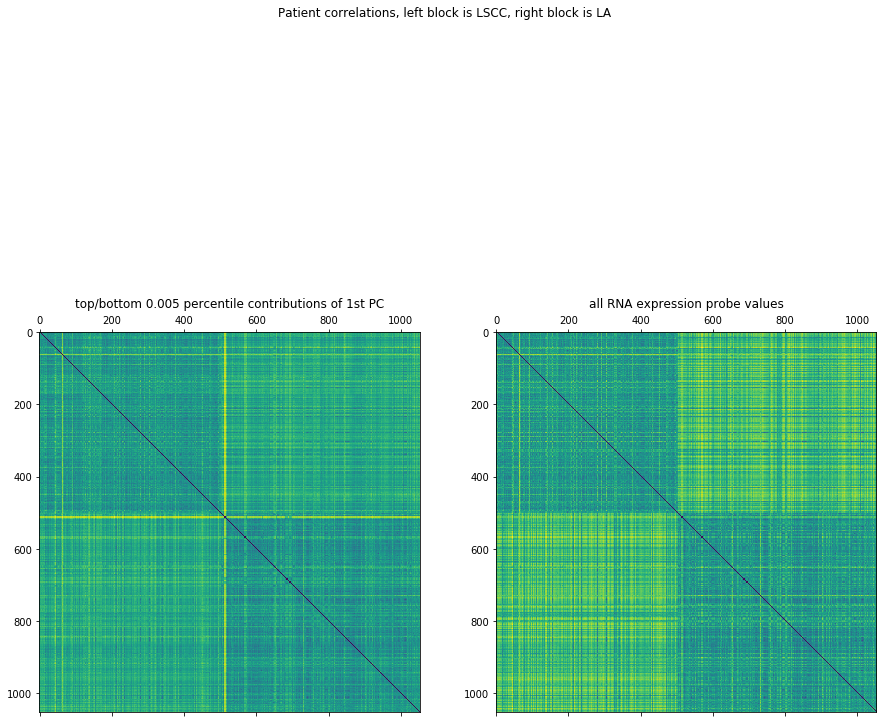

In [118]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
inflate = 1.
ax[0].matshow(corr_all**inflate)
ax[1].matshow(corr_sub**inflate)
ax[0].set_title('top/bottom 0.005 percentile contributions of 1st PC')
ax[1].set_title('all RNA expression probe values')
fig.suptitle('Patient correlations, left block is LSCC, right block is LA')

#ax[1,0].matshow(corr_sub_LSCC**inflate)
#ax[1,1].matshow(corr_all_LSCC**inflate)
#ax[1,0].set_title('Squamous, top/bottom 0.005 percentile contributions of 1st PC')
#ax[1,1].set_title('Squamous, all RNA expression probe values')

In [128]:
# Perhaps it is possible to cluster the sqeamous and adenocarcinoma samples 
# hierarchical clustering (hdbscan)
import hdbscan
hdb_cluster = hdbscan.HDBSCAN(min_cluster_size=50, alpha=.9, leaf_size=5, min_samples=None, p=None,
                              metric='euclidean', 
                              gen_min_span_tree=True,
                              approx_min_span_tree=True)
hdb_cluster.fit(corr_all.values)


/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:216: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=0.9,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=5,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
    prediction_data=False)

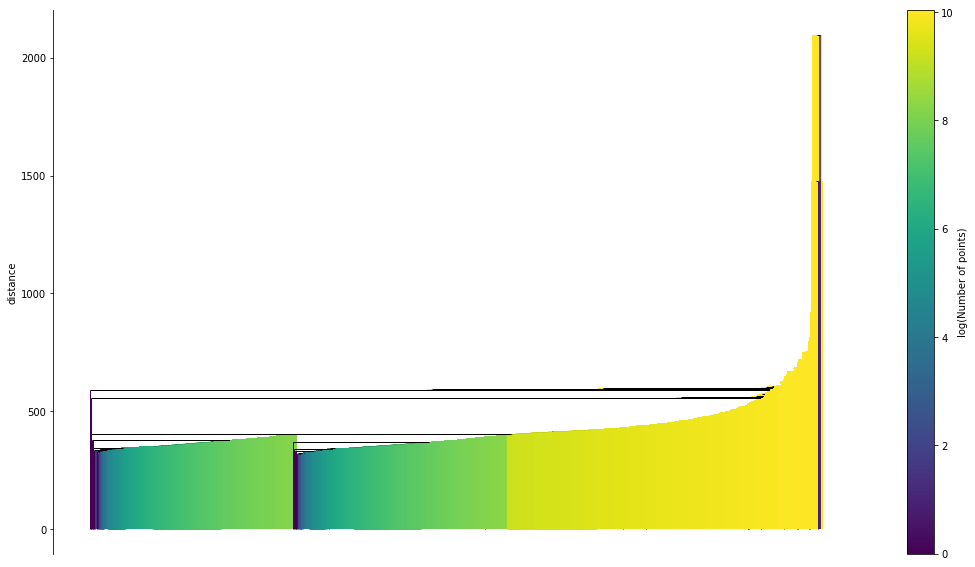

In [129]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

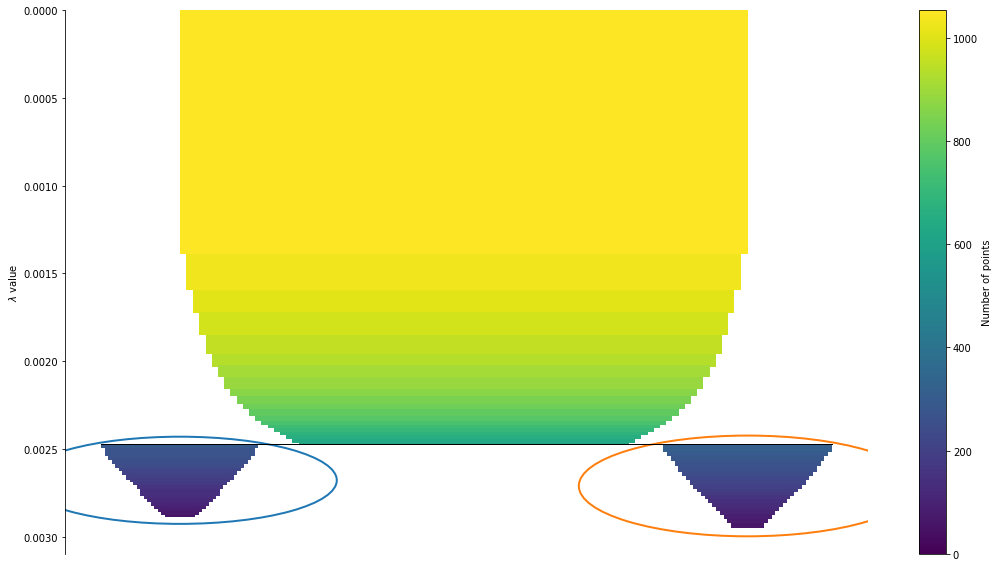

In [130]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [157]:
hdb_cluster_raw = hdbscan.HDBSCAN(min_cluster_size=10, alpha=.9, leaf_size=5, min_samples=None, p=None,
                              metric='euclidean', 
                              core_dist_n_jobs = 8,
                              gen_min_span_tree=True,
                              approx_min_span_tree=True)
hdb_cluster_raw.fit(data_dict['raw'].loc[:, GenX_columns].values)

/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:216: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=0.9,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=8, gen_min_span_tree=True, leaf_size=5,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
    prediction_data=False)

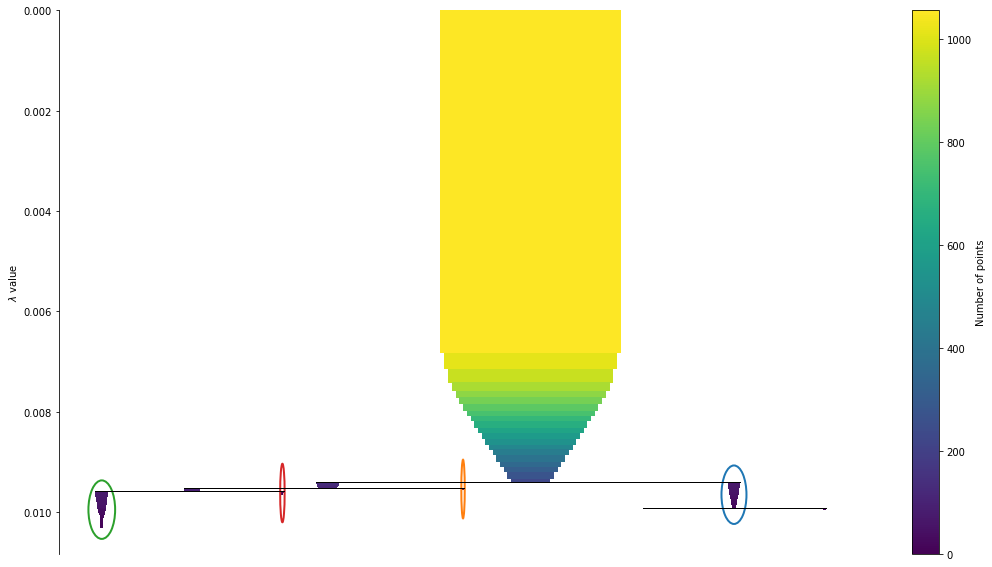

In [158]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster_raw.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [159]:
cluster_assignment_pre = pd.DataFrame(data=np.vstack((hdb_cluster.probabilities_, hdb_cluster.labels_)).T,
                                  columns=['proba', 'label'],
                                  index=corr_all.index)
cluster_assignment_raw = pd.DataFrame(data=np.vstack((hdb_cluster_raw.probabilities_, hdb_cluster_raw.labels_)).T,
                                  columns=['proba', 'label'],
                                  index=data_dict['raw'].index)

In [162]:
print(cluster_assignment_raw.label.value_counts())
print("+"*30)
print(cluster_assignment_pre.label.value_counts())

-1.0    881
 2.0     78
 0.0     73
 3.0     13
 1.0     10
Name: label, dtype: int64
++++++++++++++++++++++++++++++
-1.0    449
 1.0    313
 0.0    291
Name: label, dtype: int64


In [192]:
no_cluster_index = cluster_assignment_pre[cluster_assignment_pre.label==-1.0].index.values
cluster_0_index = cluster_assignment_pre[cluster_assignment_pre.label==1.0].index.values
cluster_1_index = cluster_assignment_pre[cluster_assignment_pre.label==0.0].index.values

In [199]:
print(data_dict['raw'].iloc[cluster_0_index,:]['Diagnosis'].value_counts())
print("+"*30)
print(data_dict['raw'].iloc[cluster_1_index,:]['Diagnosis'].value_counts())


Lung Adenocarcinoma             301
Lung Squamous Cell Carcinoma     12
Name: Diagnosis, dtype: int64
++++++++++++++++++++++++++++++
Lung Squamous Cell Carcinoma    290
Lung Adenocarcinoma               1
Name: Diagnosis, dtype: int64


We see that we naturally arrive at two clusters, starting from either the raw data or the similarity data.
These two clusters are the LSCC and LA sample groups. For the similarity data about $50\%$ of the cluster assignment are determined, for the raw data only $15\%$. 

## Classifier

By training a non-linear classifier we can identify combinations of factors that seperate the target values. 

We use the Explainable Boosting Machine developed by Microsoft. This is a Generalised Additive Model with pairwise interactions, allowing good explainability, that is augmented with boosting and bagging techniques to improve the accuracy. See [Caruana et al.](http://people.dbmi.columbia.edu/noemie/papers/15kdd.pdf)

The expectation $\mathcal{E}$ for a certain target value $y$ given a input vector $\mathbf{x}$ is given by a function $g$:
$$
g\left(\mathcal{E}[y]\right)= \beta_0 \underset{j}{\sum}f_j(x_j + \underset{i}{\sum}\underset{j}{\sum} f_{i,j} (x_i, x_j),\, i \neq j
$$

The inclusion of pairwise interaction is also interesting for studying the combination of methylation and RNA expression.


In [4]:
from interpret.glassbox import ExplainableBoostingClassifier as EBC
from interpret.glassbox import ClassificationTree as CT
from interpret.glassbox import DecisionListClassifier as DT
from interpret import show
from interpret.data import ClassHistogram
from interpret.perf import ROC

In [ ]:
# We use the PC's of the genetic expression values, and we append the phenotypical features.

In [ ]:
# We have the make sure that the phenotypical features have a suitable type.

In [ ]:
# We do not bother with the train/test splitting because we are primarily interested in feature importances
EBclassifier = EBC(n_jobs=8, n_estimators=50)
EBclassifier.fit(X, y)

In [ ]:
ebm_global = EBclassifier.explain_global(name="EBM")
show(ebm_global)

In [ ]:
ebm_local = EBclassifier.explain_local(X[:5], y[:5], name="EBM")
show(ebm_local)

In [ ]:
# in case we are interested in prediction accuracy..
#ebm_perf = ROC(EBclassifier.predict_proba).explain_perf(X_test, y_test, name='EBM')
#show(ebm_perf)

In [ ]:
## RadViz and  parallel coordinates
from yellowbrick.features import RadViz
feature_names = ['most important genes']
classes = ['LA', 'LSCC']

radvizer = RadViz(classes=classes, 
                  features=feature_names, 
                  size=(800, 300))

radvizer.fit(X_small, y)
radvizer.transform(X_small)
radvizer.poof()

In [ ]:
from yellowbrick.features import ParallelCoordinates as PARCOR
parvizer = PARCOR(classes=classes, 
                  features=feature_names,
                  normalize='standard',
                  sample=0.1, 
                  size=(800,300))

parvizer.fit(X_small, y)
parvizer.transform(X_small)
parvizer.poof()

# Key results 

* top separating RNA expression genes, their fold changes and their accuracy/f1 in separating the two cancer types
* no significant batch effect
* list of fold changes -> export to file
